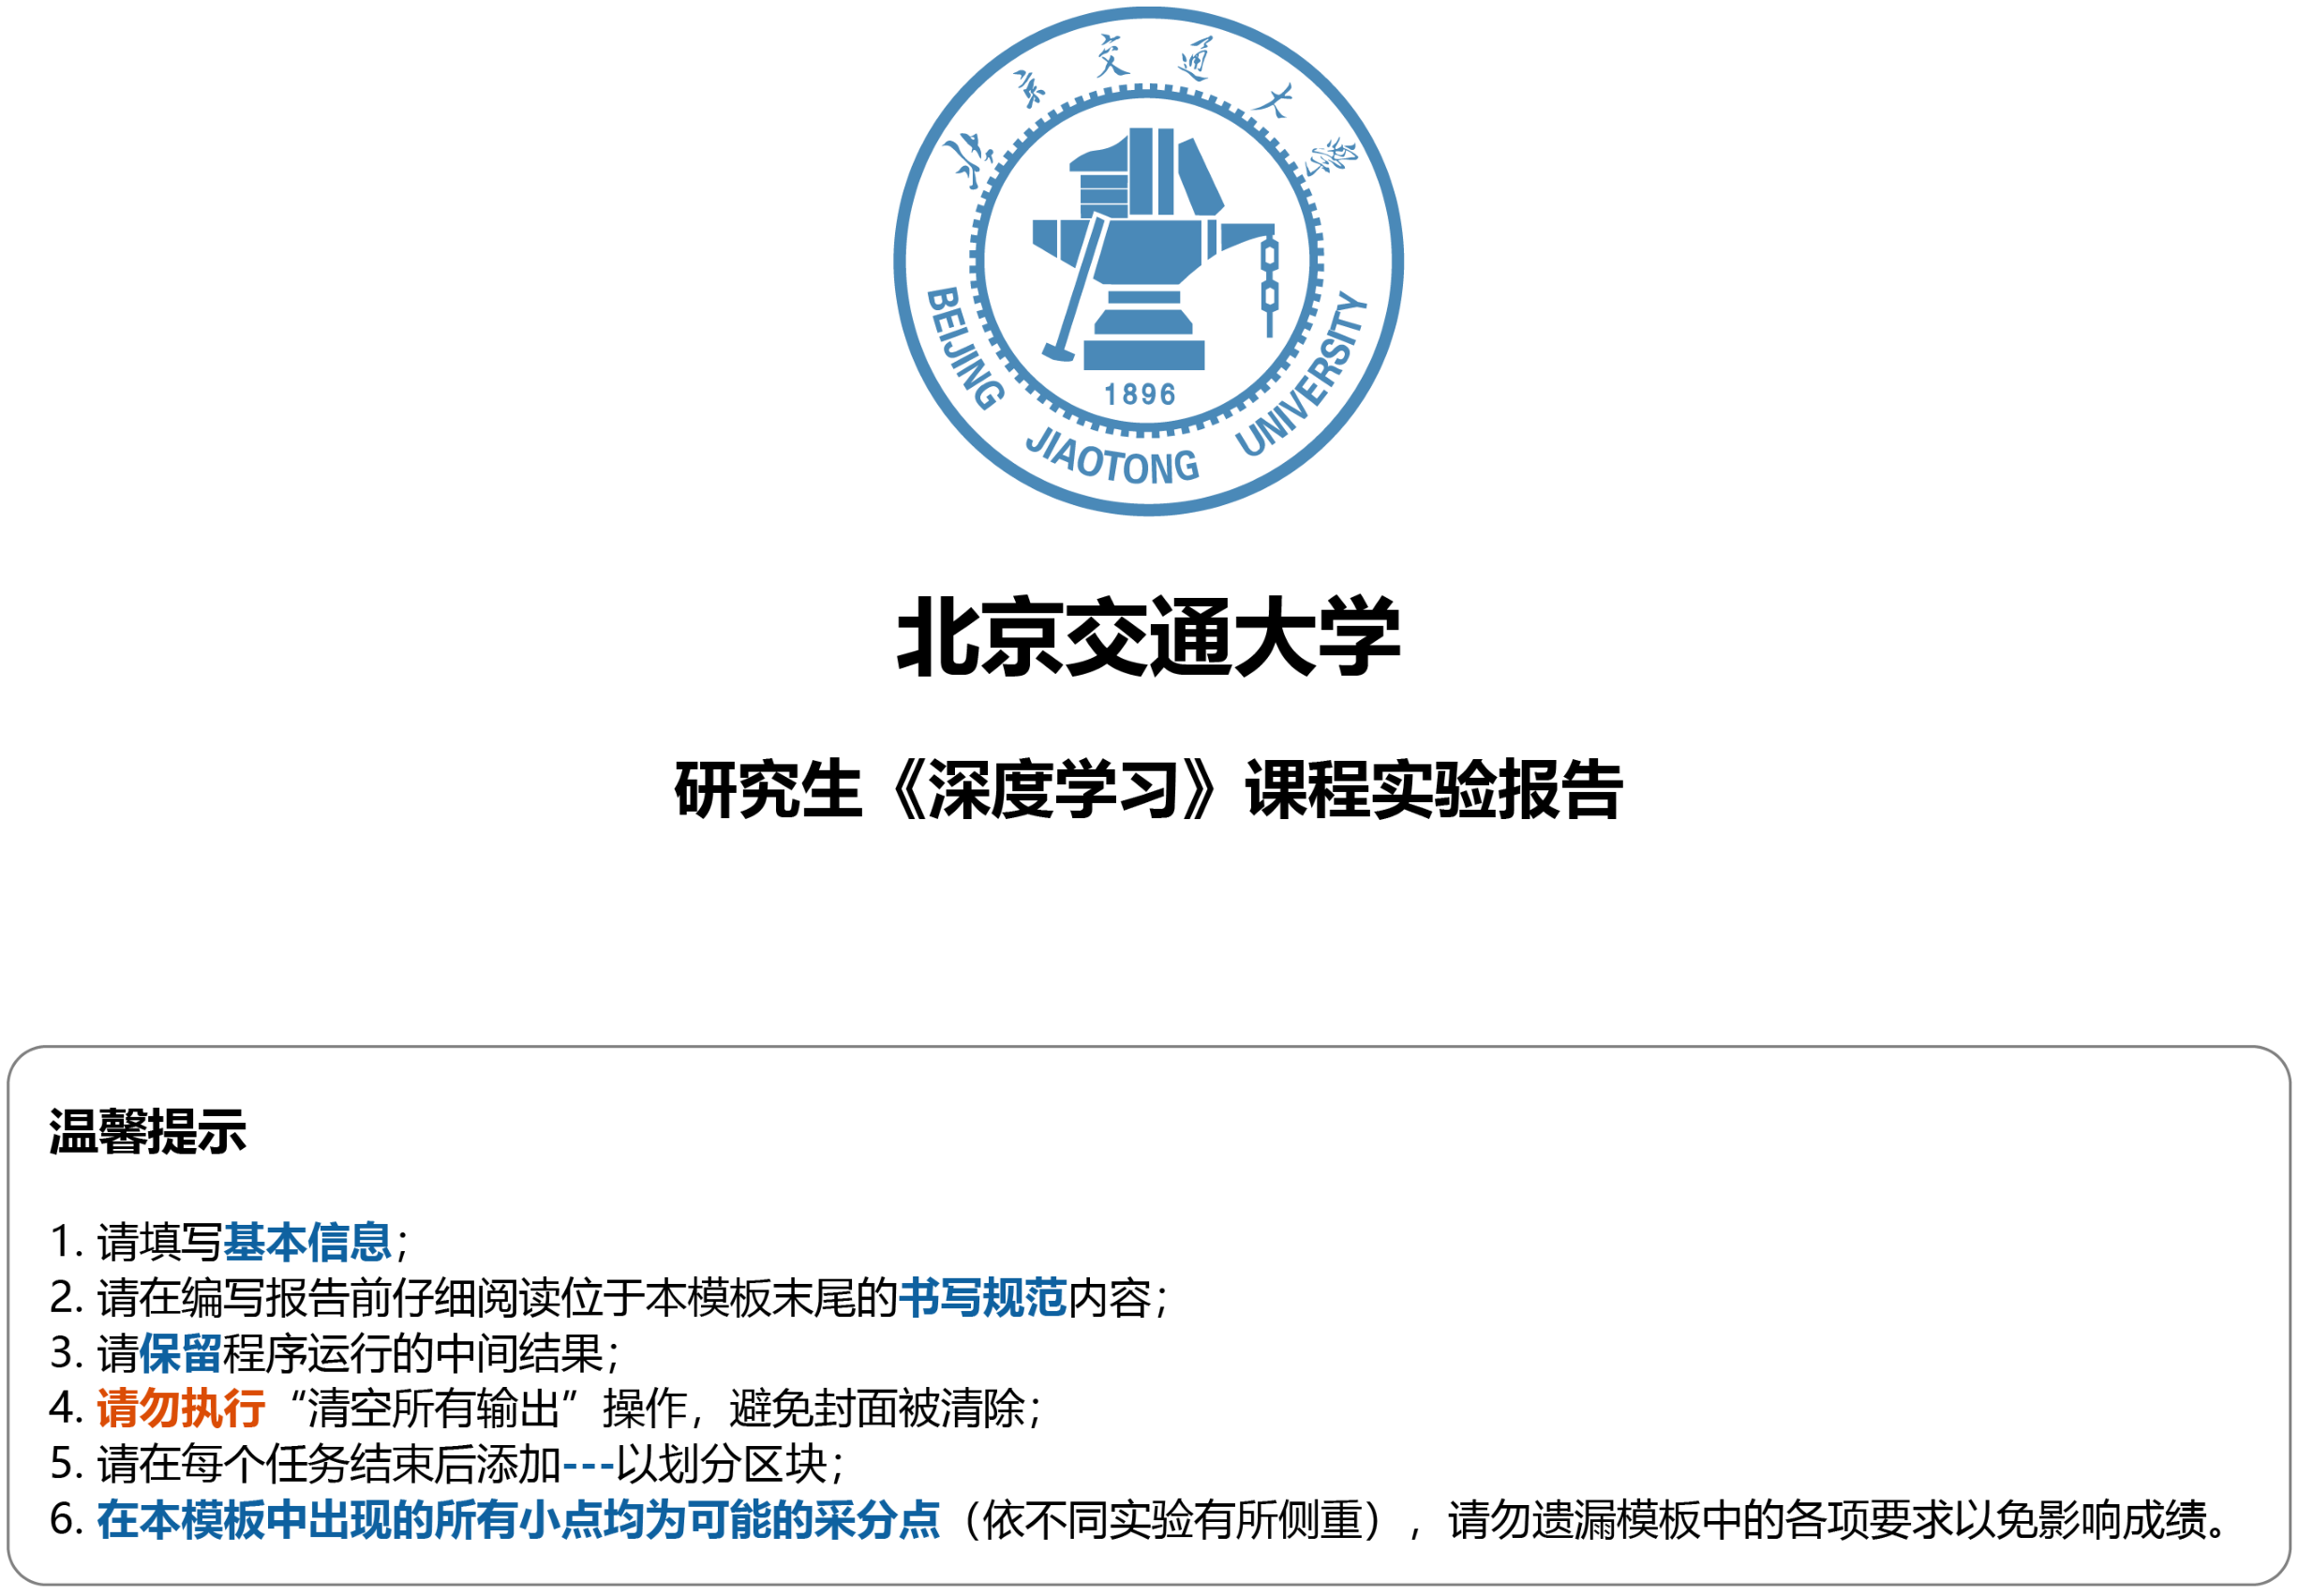

# 基本信息
1. 实验名称：卷积神经网络
2. 姓名：龙硕
3. 学号：21281165
4. 日期：12.11

---

In [32]:
import torch  
import numpy as np  
import random  
from matplotlib import pyplot as plt  
import torch.utils.data as Data  
from PIL import Image  
import os  
from torch import nn  
import torch.optim as optim  
from torch.nn import init  
import torch.nn.functional as F  
import time  
import torchvision
from torchvision import transforms,datasets
from shutil import copy, rmtree
import json

In [34]:
def split_data():
    random.seed(0)
    split_rate = 0.25

    cwd = os.getcwd()
    data_root = os.path.join(cwd, ".")
    origin_car_path = os.path.join(data_root, "cardata")
    assert os.path.exists(origin_car_path), "path '{}' does not exist.".format(origin_car_path)

    car_class = [cla for cla in os.listdir(origin_car_path)
                    if os.path.isdir(os.path.join(origin_car_path, cla))]

    train_root = os.path.join(origin_car_path, "train")
    os.makedirs(train_root, exist_ok=True)  # Create train_root if it doesn't exist
    for cla in car_class:
        mk_file(os.path.join(train_root, cla))

    test_root = os.path.join(origin_car_path, "test")
    os.makedirs(test_root, exist_ok=True)  # Create test_root if it doesn't exist
    for cla in car_class:
        mk_file(os.path.join(test_root, cla))
        
    for cla in car_class:
        cla_path = os.path.join(origin_car_path, cla)
        images = os.listdir(cla_path)
        num = len(images)
        eval_index = random.sample(images, k=int(num * split_rate))
        for index, image in enumerate(images):
            if image in eval_index:
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(test_root, cla)
                copy(image_path, new_path)
            else:
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(train_root, cla)
                copy(image_path, new_path)
            print("\r[{}] processing [{}/{}]".format(cla, index + 1, num), end="")
        print()

    print("processing done!")
    
    
split_data()

[bus] processing [219/219]
[car] processing [779/779]
[truck] processing [360/360]
processing done!


In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {"train": transforms.Compose([transforms.Resize((64,64)),
                               transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),
                                                     (0.5,0.5,0.5))]),
          "test": transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),
                                                    (0.5,0.5,0.5))])}

data_root =os.getcwd()
image_path = os.path.join(data_root,"cardata")
print(image_path)


train_dataset = datasets.ImageFolder(root=os.path.join(image_path,"train"),
                                     transform = data_transform["train"])

train_num = len(train_dataset)
print(train_num)

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size = batch_size,
                                           shuffle = True,
                                           num_workers = 0)


test_dataset = datasets.ImageFolder(root=os.path.join(image_path,"test"),
                              transform = data_transform["test"])

test_num = len(test_dataset)
print(test_num)#val_num = 364
test_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size = batch_size,
                                          shuffle=False,
                                           num_workers = 0)

print("using {} images for training, {} images for validation .".format(train_num,test_num))


using cpu device.
C:\Users\苍山沐雪\Desktop\Jupyter\NotePage\深度学习实验\cardata
1019
338
using 1019 images for training, 338 images for validation .


# 一、任务1

## 1.1 任务内容

1. 手写二维卷积的实现，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）
2. 使用torch.nn实现二维卷积，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）
3. 不同超参数的对比分析（包括卷积层数、卷积核大小、batchsize、lr等）选其中至少1-2个进行分析

In [2]:
# 自定义单通道卷积
def corr2d(X,K):
    '''
    X:输入，shape (batch_size,H,W) 
    K:卷积核，shape (k_h,k_w) 
    '''
    batch_size,H,W = X.shape
    k_h,k_w = K.shape
    #初始化结果矩阵
    Y = torch.zeros((batch_size,H-k_h+1,W-k_w+1)).to(device)
    for i in range(Y.shape[1]):  
        for j in range(Y.shape [2]):  
            Y[:,i,j] = (X[:,i:i+k_h,j:j+k_w]* K).sum()  
    return Y

#自定义多通道卷积
def corr2d_multi_in(X,K):
    '''
    输入X:维度(batch_size,C_in,H, W)
    卷积核K:维度(C_in,k_h,k_w)  
    输出:维度(batch_size,H_out,W_out)  
    '''
    #先计算第一通道  
    res = corr2d(X[:,0,:,:], K[0,:,:])  
    for i in range(1, X.shape[1]):  
        #按通道相加  
        res += corr2d(X[:,i,:,:], K[i,:,:])  
    return res

#自定义多个多通道卷积  
def corr2d_multi_in_out(X, K):  
 # X: shape (batch_size,C_in,H,W)  
 # K: shape (C_out,C_in,h,w)  
 # Y: shape(batch_size,C_out,H_out,W_out)  
    return torch.stack([corr2d_multi_in(X, k) for k in K],dim=1) 


In [2]:
class MyConv2D(nn.Module):  
    def __init__(self,in_channels, out_channels,kernel_size):  
        super(MyConv2D,self).__init__()  
        #初始化卷积层的2个参数:卷积核、偏差  
       #isinstance判断类型  
        if isinstance(kernel_size,int):  
            kernel_size = (kernel_size,kernel_size)  
            self.weight = nn.Parameter(torch.randn((out_channels, in_channels) + kernel_size)).to(device)  
            self.bias = nn.Parameter(torch.randn(out_channels,1,1)).to(device)  
    def forward(self,x):    #x:输入图片，维度(batch_size,C_in,H,W) 
        return corr2d_multi_in_out(x,self.weight) + self.bias

In [2]:
#添加自定义卷积层到模块中  
class MyConvModule(nn.Module):  
    def __init__(self):  
        super(MyConvModule,self).__init__()  
        #定义一层卷积层  
        self.conv = nn.Sequential(  
            MyConv2D(in_channels = 3,out_channels = 32,kernel_size = 3),  
            nn.BatchNorm2d(32),  
            # inplace-选择是否进行覆盖运算  
            nn.ReLU(inplace=True))  
        #输出层,将通道数变为分类数量  
        self.fc = nn.Linear(32,num_classes)  

    def forward(self,x):  
        #图片经过一层卷积，输出维度变为(batch_size,C_out,H,W)  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）64-3/1 + 1 =62  
        out = F.avg_pool2d(out,62)  
        #将张量out从shape batchx32x1x1 变为 batch x32  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out

In [2]:
num_classes = 3  
lr = 0.001
epochs = 5
#初始化模型  
net = MyConvModule().to(device)  
#使用多元交叉熵损失函数  
criterion = nn.CrossEntropyLoss()  
#使用Adam优化器  
optimizer = optim.Adam(net.parameters(),lr = lr)  


In [2]:
def train_epoch(net, data_loader, device):  

    net.train() #指定当前为训练模式  
    train_batch_num = len(data_loader) #记录共有多少个batch   
    total_1oss = 0 #记录Loss  
    correct = 0 #记录共有多少个样本被正确分类  
    sample_num = 0 #记录样本总数  

    #遍历每个batch进行训练  
    for batch_idx, (data,target) in enumerate (data_loader): 
        t1 = time.time()
        #将图片放入指定的device中  
        data = data.to(device).float()  
        #将图片标签放入指定的device中  
        target = target.to(device).long()  
        #将当前梯度清零  
        optimizer.zero_grad()  
        #使用模型计算出结果  
        output = net(data)  
        #计算损失  
        loss = criterion(output, target.squeeze())  
        #进行反向传播  
        loss.backward()  
        optimizer.step()  
        #累加loss  
        total_1oss += loss.item( )  
        #找出每个样本值最大的idx,即代表预测此图片属于哪个类别  
        prediction = torch.argmax(output, 1)  
        #统计预测正确的类别数量  
        correct += (prediction == target).sum().item()  
        #累加当前的样本总数  
        sample_num += len(prediction)
        #if batch_idx//5 ==0:
        t2 = time.time()
        print("processing:{}/{},消耗时间{}s".
                      format(batch_idx+1,len(data_loader),t2-t1))
            
    #计算平均oss与准确率  
    loss = total_1oss / train_batch_num  
    acc = correct / sample_num  
    return loss, acc  

def test_epoch(net, data_loader, device):  
    net.eval() #指定当前模式为测试模式  
    test_batch_num = len(data_loader)  
    total_loss = 0  
    correct = 0  
    sample_num = 0  
    #指定不进行梯度变化  
    with torch.no_grad():  
        for batch_idx, (data, target) in enumerate(data_loader):  
            data = data.to(device).float()  
            target = target.to(device).long()   
            output = net(data)  
            loss = criterion(output, target)  
            total_loss += loss.item( )  
            prediction = torch.argmax(output, 1)  
            correct += (prediction == target).sum().item()  
            sample_num += len(prediction)  
    loss = total_loss / test_batch_num  
    acc = correct / sample_num  
    return loss,acc

In [2]:
#### 存储每一个epoch的loss与acc的变化，便于后面可视化  
train_loss_list = []  
train_acc_list = []  
test_loss_list = []  
test_acc_list = []  
time_list = []  
timestart = time.time()  
#进行训练  
for epoch in range(epochs):  
    #每一个epoch的开始时间  
    epochstart = time.time()  

    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device )  
    #在测试集上验证  
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)  

    #每一个epoch的结束时间  
    elapsed = (time.time() - epochstart)  
    #保存各个指际  
    train_loss_list.append(train_loss)  
    train_acc_list.append(train_acc )  
    test_loss_list.append(test_loss)  
    test_acc_list.append(test_acc)  
    time_list.append(elapsed)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,elapsed))  
#计算总时间  
timesum = (time.time() - timestart)  
print('The total time is %fs',timesum) 

In [2]:
def Draw(*args,xlabel = "epoch",ylabel = "loss"):#
    for i in args:
        x = np.linspace(0,len(i[0]),len(i[0]))  
        plt.plot(x,i[0],label=i[1],linewidth=1.5)  
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
Draw([train_acc_list,"train_acc"],[test_acc_list,"test_acc"],ylabel = "acc")
Draw([train_loss_list,"train_loss"],[test_loss_list,"test_loss"])

In [2]:
# pytorch封装卷积层
class ConvModule(nn.Module):  
    def __init__(self):  
        super(ConvModule,self).__init__()  
        #定义三层卷积层  
        self.conv = nn.Sequential(  
            #第一层  
            nn.Conv2d(in_channels = 3,out_channels = 32,
                         kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(32),  
            # inplace-选择是否进行覆盖运算  
            nn.ReLU(inplace=True),  
            #第二层  
            nn.Conv2d(in_channels = 32,out_channels = 64,
                         kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(64),  
            # inplace-选择是否进行覆盖运算  
            nn.ReLU(inplace=True),  
            #第三层  
            nn.Conv2d(in_channels = 64,out_channels = 128,
                        kernel_size = 3 , stride = 1,padding=0),  
            nn.BatchNorm2d(128),  
            # inplace-选择是否进行覆盖运算  
            nn.ReLU(inplace=True)  
        )  
        #输出层,将通道数变为分类数量  
        self.fc = nn.Linear(128,num_classes)  

    def forward(self,x):  
        #图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)  
        out = self.conv(x)  
        #使用平均池化层将图片的大小变为1x1,第二个参数为最后输出的长和宽（这里默认相等了）（64-3）/1 + 1 =62  (62-3)/1+1 =60 (60-3)/1+1 =58  
        out = F.avg_pool2d(out,58)  
        #将张量out从shape batchx128x1x1 变为 batch x128  
        out = out.squeeze()  
        #输入到全连接层将输出的维度变为3  
        out = self.fc(out)  
        return out 

In [2]:
# 更换为ConvModule
net = ConvModule().to(device)

#### 存储每一个epoch的loss与acc的变化，便于后面可视化  
train_loss_list = []  
train_acc_list = []  
test_loss_list = []  
test_acc_list = []  
time_list = []  
timestart = time.time()  
# 进行训练  
for epoch in range(epochs):  
    #每一个epoch的开始时间  
    epochstart = time.time()  

    #在训练集上训练  
    train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device )  
    #在测试集上验证  
    test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)  

    #每一个epoch的结束时间  
    elapsed = (time.time() - epochstart)  
    #保存各个指际  
    train_loss_list.append(train_loss)  
    train_acc_list.append(train_acc )  
    test_loss_list.append(test_loss)  
    test_acc_list.append(test_acc)  
    time_list.append(elapsed)  
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,elapsed))  
#计算总时间  
timesum = (time.time() - timestart)  
print('The total time is %fs',timesum) 


In [2]:
Draw([train_acc_list,"train_acc"],[test_acc_list,"test_acc"],ylabel = "acc")
Draw([train_loss_list,"train_loss"],[test_loss_list,"test_loss"])

In [2]:
lr_list = [0.1,0.01,0.001]
for lr in lr_list :
    print("lr：",lr)
    optimizer = optim.Adam(net.parameters(),lr = lr)
    
    # 更换为ConvModule
    net = ConvModule().to(device)

    #### 存储每一个epoch的loss与acc的变化，便于后面可视化  
    train_loss_list = []  
    train_acc_list = []  
    test_loss_list = []  
    test_acc_list = []  
    time_list = []  
    timestart = time.time()  
    #进行训练  
    for epoch in range(epochs):  
        #每一个epoch的开始时间  
        epochstart = time.time()  

        #在训练集上训练  
        train_loss, train_acc = train_epoch(net,data_loader=train_loader, device=device )  
        #在测试集上验证  
        test_loss, test_acc = test_epoch(net,data_loader=test_loader, device=device)  

        #每一个epoch的结束时间  
        elapsed = (time.time() - epochstart)  
        #保存各个指际  
        train_loss_list.append(train_loss)  
        train_acc_list.append(train_acc )  
        test_loss_list.append(test_loss)  
        test_acc_list.append(test_acc)  
        time_list.append(elapsed)
        print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs'%(epoch+1, train_loss,test_loss,train_acc,test_acc,elapsed)) 
    Draw([train_acc_list,"train_acc"],[test_acc_list,"test_acc"],ylabel = "acc")
    Draw([train_loss_list,"train_loss"],[test_loss_list,"test_loss"])


## 1.3 实验结果分析

> 本部分位置灵活，若结果位于`实验代码`中，则可在输出结果后添加本部分。请注意如下几点：
> 1. 添加本部分的位置应添加`## 实验结果分析`二级标题；
> 2. 对比不同参数性能时至少要有三组参数以提高说服力；
> 3. 不能只有图或表而没有文字分析；
> 4. 避免在没有给出证明的情况下使用“完美”、“完全”、“消除”、“彻底”等绝对表述；
> 5. **应对贴出的图和表进行描述（如趋势等），同时分析出现相关现象的原因**。

# 二、任务2

## 2.1 任务内容

1. 使用torch.nn实现空洞卷积，要求dilation满足HDC条件（如1,2,5）且要堆叠多层并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）
2. 将空洞卷积模型的实验结果与卷积模型的结果进行分析比对，训练时间、预测精度、Loss变化等角度分析
3. 不同超参数的对比分析（包括卷积层数、卷积核大小、不同dilation的选择，batchsize、lr等）选其中至少1-2个进行分析（选做）

---

In [2]:
# pytorch封装卷积层
class DilatedConvModule(nn.Module):
    def __init__(self):
        super(DilatedConvModule, self).__init__()
        # 定义三层卷积层
        self.conv = nn.Sequential(
            # 第一层
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, stride=1, padding=0, dilation=1),
            nn.BatchNorm2d(32),
            # inplace-选择是否进行覆盖运算
            nn.ReLU(inplace=True),
            # 第二层
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=0, dilation=2),
            nn.BatchNorm2d(64),
            # inplace-选择是否进行覆盖运算
            nn.ReLU(inplace=True),
            # 第三层
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=0, dilation=5),
            nn.BatchNorm2d(128),
            # inplace-选择是否进行覆盖运算
            nn.ReLU(inplace=True)
        )
        # 输出层,将通道数变为分类数量
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # 图片经过三层卷积，输出维度变为(batch_size,C_out,H,W)
        out = self.conv(x)
        # 使用平均池化层将图片的大小变为1x1
        out = F.avg_pool2d(out, 16)
        # 将张量out从shape batchx128x1x1 变为 batch x128
        out = out.squeeze()
        # 输入到全连接层将输出的维度变为3
        out = self.fc(out)
        return out


def train_epoch(net, data_loader, device):
    net.train()  # 指定当前为训练模式
    train_batch_num = len(data_loader)  # 记录共有多少个batch
    total_1oss = 0  # 记录Loss
    correct = 0  # 记录共有多少个样本被正确分类
    sample_num = 0  # 记录样本总数

    # 遍历每个batch进行训练
    for batch_idx, (data, target) in enumerate(data_loader):
        t1 = time.time()
        # 将图片放入指定的device中
        data = data.to(device).float()
        # 将图片标签放入指定的device中
        target = target.to(device).long()
        # 将当前梯度清零
        optimizer.zero_grad()
        # 使用模型计算出结果
        output = net(data)
        # 计算损失
        loss = criterion(output, target.squeeze())
        # 进行反向传播
        loss.backward()
        optimizer.step()
        # 累加loss
        total_1oss += loss.item()
        # 找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        # 统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        # 累加当前的样本总数
        sample_num += len(prediction)
        # if batch_idx//5 ==0:
        t2 = time.time()
        print("processing:{}/{},消耗时间{}s".
              format(batch_idx + 1, len(data_loader), t2 - t1))

    # 计算平均oss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc


def test_epoch(net, data_loader, device):
    net.eval()  # 指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    # 指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [2]:
num_classes = 10
epochs = 5
lr = 0.001
batch_size = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
net = DilatedConvModule().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [2]:
#### 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
time_list = []
timestart = time.time()
# 进行训练
for epoch in range(epochs):
    # 每一个epoch的开始时间
    epochstart = time.time()

    # 在训练集上训练
    train_loss, train_acc = train_epoch(net, data_loader=cifar_trainloader, device=device)
    # 在测试集上验证
    test_loss, test_acc = test_epoch(net, data_loader=cifar_testloader, device=device)

    # 每一个epoch的结束时间
    elapsed = (time.time() - epochstart)
    # 保存各个指际
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    time_list.append(elapsed)
    print('epoch %d, train_loss %.6f,test_loss %.6f,train_acc %.6f,test_acc %.6f,Time used %.6fs' % (
        epoch + 1, train_loss, test_loss, train_acc, test_acc, elapsed))
# 计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs', timesum)

In [2]:
Draw([train_acc_list,"train_acc"],[test_acc_list,"test_acc"],ylabel = "acc")
Draw([train_loss_list,"train_loss"],[test_loss_list,"test_loss"]

In [2]:
# 实验代码
print("Hello World!")

In [2]:
# 实验代码
print("Hello World!")

# 二、任务3

## 3.1 任务内容

1. 实现给定结构的残差网络，在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）
2. 将残差网络与空洞卷积相结合，在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示） （选做）


In [2]:
# 实验代码
print("Hello World!")

In [2]:
# 实验代码
print("Hello World!")

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)  # Add the shortcut connection
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Stack of residual blocks
        self.layer1 = self.make_layer(32, 32, blocks=2, stride=1)
        self.layer2 = self.make_layer(32, 64, blocks=2, stride=2)
        self.layer3 = self.make_layer(64, 128, blocks=2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [2]:
def train_epoch(net, data_loader, criterion, optimizer, device):
    net.train()  # 指定当前为训练模式
    train_batch_num = len(data_loader)  # 记录共有多少个batch
    total_1oss = 0  # 记录Loss
    correct = 0  # 记录共有多少个样本被正确分类
    sample_num = 0  # 记录样本总数

    # 遍历每个batch进行训练
    for batch_idx, (data, target) in enumerate(data_loader):
        t1 = time.time()
        # 将图片放入指定的device中
        data = data.to(device).float()
        # 将图片标签放入指定的device中
        target = target.to(device).long()
        # 将当前梯度清零
        optimizer.zero_grad()
        # 使用模型计算出结果
        output = net(data)
        # 计算损失
        loss = criterion(output, target.squeeze())
        # 进行反向传播
        loss.backward()
        optimizer.step()
        # 累加loss
        total_1oss += loss.item()
        # 找出每个样本值最大的idx,即代表预测此图片属于哪个类别
        prediction = torch.argmax(output, 1)
        # 统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        # 累加当前的样本总数
        sample_num += len(prediction)
        # if batch_idx//5 ==0:
        t2 = time.time()
        print("processing:{}/{},消耗时间{}s".
              format(batch_idx + 1, len(data_loader), t2 - t1))

    # 计算平均oss与准确率
    loss = total_1oss / train_batch_num
    acc = correct / sample_num
    return loss, acc


def test_epoch(net, data_loader, criterion, device):
    net.eval()  # 指定当前模式为测试模式
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    # 指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [2]:
num_classes = 10
epochs = 5
lr = 0.001
batch_size = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Initialize the ResNet model, criterion, and optimizer
resnet = ResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

# Lists to store metrics for visualization
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
time_list = []

# Training and evaluation loop
for epoch in range(epochs):
    start_time = time.time()

    # Training
    train_loss, train_acc = train_epoch(resnet, train_loader, criterion, optimizer, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Testing
    test_loss, test_acc = test_epoch(resnet, test_loader, criterion, device)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    elapsed_time = time.time() - start_time
    time_list.append(elapsed_time)

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, '
          f'Train Acc: {train_acc:.6f}, Test Acc: {test_acc:.6f}, Time used: {elapsed_time:.2f}s')

In [2]:
Draw([train_acc_list,"train_acc"],[test_acc_list,"test_acc"],ylabel = "acc")
Draw([train_loss_list,"train_loss"],[test_loss_list,"test_loss"])

In [2]:
# 实验代码
print("Hello World!")

## 2.3 实验结果分析

> 本部分位置灵活，若结果位于`实验代码`中，则可在输出结果后添加本部分。请注意如下几点：
> 1. 添加本部分的位置应添加`## 实验结果分析`二级标题；
> 2. 对比不同参数性能时至少要有三组参数以提高说服力；
> 3. 不能只有图或表而没有文字分析；
> 4. 避免在没有给出证明的情况下使用“完美”、“完全”、“消除”、“彻底”等绝对表述；
> 5. **应对贴出的图和表进行描述（如趋势等），同时分析出现相关现象的原因**。

---

# A1 实验心得

> 1. 请重视总结心得体会，该部分计分；
> 2. 至少应包括一个具体任务心得或代码排错过程，而不是仅有诸如“学到了很多”的内容。

# A2 参考文献

> 主要包含实验过程中涉及到的参考资料或者借鉴别人的材料等，如果没有可以不写。

1. 参考文献1；
2. 参考文献2；
3. ……